In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import torch
import numpy as np
from math import *
import time
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import cmcrameri.cm as cmc

%matplotlib inline
plt.style.use('/home/beams/B313762/stylesheet.mplstyle')

## Load data + pre-processing

In [2]:
data_folder = '/data/aileen/DONUT_data'

# Simulated SXDM scan with random domains
print('Loading simulated scan')
sim_sample = np.load(os.path.join(data_folder, 'sim_random_sample.npy')).astype(np.float32)
sim_sample = np.reshape(sim_sample, (sim_sample.shape[0]*sim_sample.shape[1], sim_sample.shape[2], sim_sample.shape[3]))
sim_sample[np.isnan(sim_sample)] = 0
rng = np.random.default_rng()
for i in range(sim_sample.shape[0]):
    sim_sample[i] = (sim_sample[i] / np.max(sim_sample[i])) * 7
    sim_sample[i] = rng.poisson(sim_sample[i])

gt_strain = np.load(os.path.join(data_folder, 'gt_strain_random.npy'))
gt_tilt_lr = np.load(os.path.join(data_folder, 'gt_tilt_lr_random.npy'))
gt_tilt_ud = np.load(os.path.join(data_folder, 'gt_tilt_ud_random.npy'))

print('Loading simulation fit')
sim_strain_fit = np.load(os.path.join(data_folder, 'strain_fit_random.npy'))
sim_tilt_lr_fit = np.load(os.path.join(data_folder, 'tilt_lr_fit_random.npy'))
sim_tilt_ud_fit = np.load(os.path.join(data_folder, 'tilt_ud_fit_random.npy'))

sim_strain_fit = np.reshape(sim_strain_fit, (8, 8))
sim_tilt_lr_fit = np.reshape(sim_tilt_lr_fit, (8, 8))
sim_tilt_ud_fit = np.reshape(sim_tilt_ud_fit, (8, 8))


Loading simulated scan
Loading simulation fit


## Convert to PyTorch Dataset

In [3]:
class DiffDataset(Dataset):
    """Makes PyTorch Dataset object for diffraction data (images)."""
    
    def __init__(self, data, params=None, transform=None):
        self.data = data
        if isinstance(params, np.ndarray):
            self.params = params
        else:
            self.params = None
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = self.data[idx]
        if isinstance(self.params, np.ndarray):
            lattice = self.params[idx]
            sample={'image': image, 'lattice': lattice}
        else:
            sample = {'image': image, 'lattice': None}
            
        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    """Convert numpy arrays to Tensors"""
    def __call__(self, sample):
        image = sample['image']
        if isinstance(sample['lattice'], np.ndarray):
            lattice = sample['lattice']
            return {'image': torch.unsqueeze(torch.from_numpy(image), 0), 'lattice': torch.from_numpy(lattice)}
        return {'image': torch.unsqueeze(torch.from_numpy(image), 0), 'lattice': 0}

In [4]:
sim_dataset = DiffDataset(data=sim_sample, params=None, transform=ToTensor())

for i, sample in enumerate(sim_dataset):
    print(i, sample['image'].size())
    print(sample['image'].dtype)
    
    if i == 4:
        break

0 torch.Size([1, 64, 64])
torch.float32
1 torch.Size([1, 64, 64])
torch.float32
2 torch.Size([1, 64, 64])
torch.float32
3 torch.Size([1, 64, 64])
torch.float32
4 torch.Size([1, 64, 64])
torch.float32


## DataLoader

In [5]:
BATCH_SIZE = 16
MODEL_SAVE_PATH = '/home/beams/AILEENLUO/DONUT/models'

In [6]:
# Use a DataLoader to iterate through the Dataset
simloader = DataLoader(sim_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model definition

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout_rate=0.0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(), 
            nn.Dropout(dropout_rate),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
    def forward(self, x: torch.Tensor):
        return self.conv(x)

# Autoencoder building blocks
class DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d((2, 2))
        
    def forward(self, x: torch.Tensor):
        return self.pool(x)
    
class UpSample(nn.Module):
    def __init__(self):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        
    def forward(self, x: torch.Tensor):
        return self.up(x)
    
class DoubleConvUp(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout_rate=0.0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(), 
            nn.Dropout(dropout_rate)
        )
        
    def forward(self, x: torch.Tensor):
        return self.conv(x)

In [8]:
class Encoder(nn.Module):
    def __init__(self, in_channels: int, dropout_rate=0.0):
        super().__init__()
        self.down_conv = nn.ModuleList([DoubleConv(i, o, dropout_rate) for i, o in 
                                        [(in_channels, 16), (16, 32), (32, 64), (64, 128), (128, 256), 
                                         (256, 256)]])
        self.down_sample = nn.ModuleList([DownSample() for _ in range(6)])
        self.fc = nn.Linear(256, 3)
        
    def forward(self, x: torch.Tensor):
        for i in range(len(self.down_conv)):
            x = self.down_conv[i](x)
            x = self.down_sample[i](x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

## Inference

In [9]:
# See visualizations.ipynb for example usage of the full model for inference
cnn = Encoder(1) # Encoder for fast inference, best_model_encoder.pth'
run_path = os.path.join(MODEL_SAVE_PATH, 'sim_noisy_exp')
cnn.load_state_dict(torch.load(os.path.join(run_path, 'best_model_encoder.pth')))
next(cnn.parameters()).device

device(type='cpu')

In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_predictions(model, dataloader, encoder_only=True, batch_size=BATCH_SIZE, device=DEVICE):
    """Returns network predictions and labels by any model on any dataset."""
    
    pred_vals = np.zeros((len(dataloader)-1, batch_size, 3))
    if encoder_only == False:
        pred_imgs = np.zeros((len(dataloader)-1, batch_size, 64, 64))
        pred_recon = np.zeros((len(dataloader)-1, batch_size, 64, 64))
        gt_imgs = np.zeros(pred_imgs.shape)
    gt_vals = np.zeros(pred_vals.shape)
    model.to(device)
    print(next(model.parameters()).device)
    inference_time = []
    t0 = time.time()
    
    model.eval()
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader)):
            t1 = time.time()
            images = data['image'].to(device)
            if isinstance(data['lattice'], torch.Tensor):
                labels = data['lattice'].to(device)
            if encoder_only == False:
                output_recon, output_imgs, output_vals = model(images)
            else: 
                output_enc = model(images)
                output_vals = 1.7159 * torch.tanh((2/3) * output_enc)
            if i < pred_vals.shape[0]:
                pred_vals[i] = output_vals.detach().cpu().numpy()
                if encoder_only == False:
                    pred_imgs[i] = output_imgs.squeeze().detach().cpu().numpy()
                    pred_recon[i] = output_recon.squeeze().detach().cpu().numpy()
                    gt_imgs[i] = images.squeeze().detach().cpu().numpy()
                if isinstance(data['lattice'], torch.Tensor) and data['lattice'].shape==(data['lattice'].shape[0], 3):
                    gt_vals[i] = labels.detach().cpu().numpy()
                inference_time.append(time.time()-t1)
            else:
                # The last batch may be a different size
                pred_vals_last = output_vals.detach().cpu().numpy()
                gt_vals_last = np.zeros(pred_vals_last.shape)
                if encoder_only == False:
                    pred_imgs_last = output_imgs.squeeze(dim=1).detach().cpu().numpy()
                    pred_recon_last = output_recon.squeeze(dim=1).detach().cpu().numpy()
                    gt_imgs_last = images.squeeze().detach().cpu().numpy()
                    if gt_imgs_last.ndim == 2:
                        gt_imgs_last = gt_imgs_last[np.newaxis, :, :]
                if isinstance(data['lattice'], torch.Tensor) and data['lattice'].shape==(data['lattice'].shape[0], 3):
                    gt_vals_last = labels.detach().cpu().numpy()
                inference_time.append(time.time()-t1)
    
    print('Total inference time (s): ', time.time()-t0)
    print('Average inference time (s): ', np.mean(inference_time[2:len(inference_time)-1])/batch_size)
    print('Inference time error (s): ', np.std(inference_time[2:len(inference_time)-1])/batch_size)
    pred_vals = np.reshape(pred_vals, (pred_vals.shape[0]*pred_vals.shape[1], pred_vals.shape[2]))
    if encoder_only == False:
        pred_imgs = np.reshape(pred_imgs, (pred_imgs.shape[0]*pred_imgs.shape[1], 
                                           pred_imgs.shape[2], pred_imgs.shape[3]))
        pred_recon = np.reshape(pred_recon, (pred_recon.shape[0]*pred_recon.shape[1], pred_recon.shape[2],
                                             pred_recon.shape[3]))
        gt_imgs = np.reshape(gt_imgs, (gt_imgs.shape[0]*gt_imgs.shape[1], gt_imgs.shape[2], gt_imgs.shape[3]))
        pred_imgs = np.vstack((pred_imgs, pred_imgs_last))
        pred_recon = np.vstack((pred_recon, pred_recon_last))
        gt_imgs = np.vstack((gt_imgs, gt_imgs_last))
    gt_vals = np.reshape(gt_vals, (gt_vals.shape[0]*gt_vals.shape[1], gt_vals.shape[2]))
    pred_vals = np.vstack((pred_vals, pred_vals_last))
    gt_vals = np.vstack((gt_vals, gt_vals_last))
    if encoder_only == False:
        return pred_vals, pred_imgs, pred_recon, gt_vals, gt_imgs
    return pred_vals, gt_vals

In [11]:
pred_vals_sim, _ = get_predictions(cnn, simloader, encoder_only=True)

cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.26415181159973145
Average inference time (s):  7.604062557220459e-05
Inference time error (s):  0.0


## Statistics

In [12]:
# Simulated data
pred_sim_strain = np.reshape(pred_vals_sim[:, 0]/100, (8, 8))
pred_sim_tilt_lr = np.reshape(pred_vals_sim[:, 1]/10, (8, 8))
pred_sim_tilt_ud = np.reshape(pred_vals_sim[:, 2]/5, (8, 8))

[]

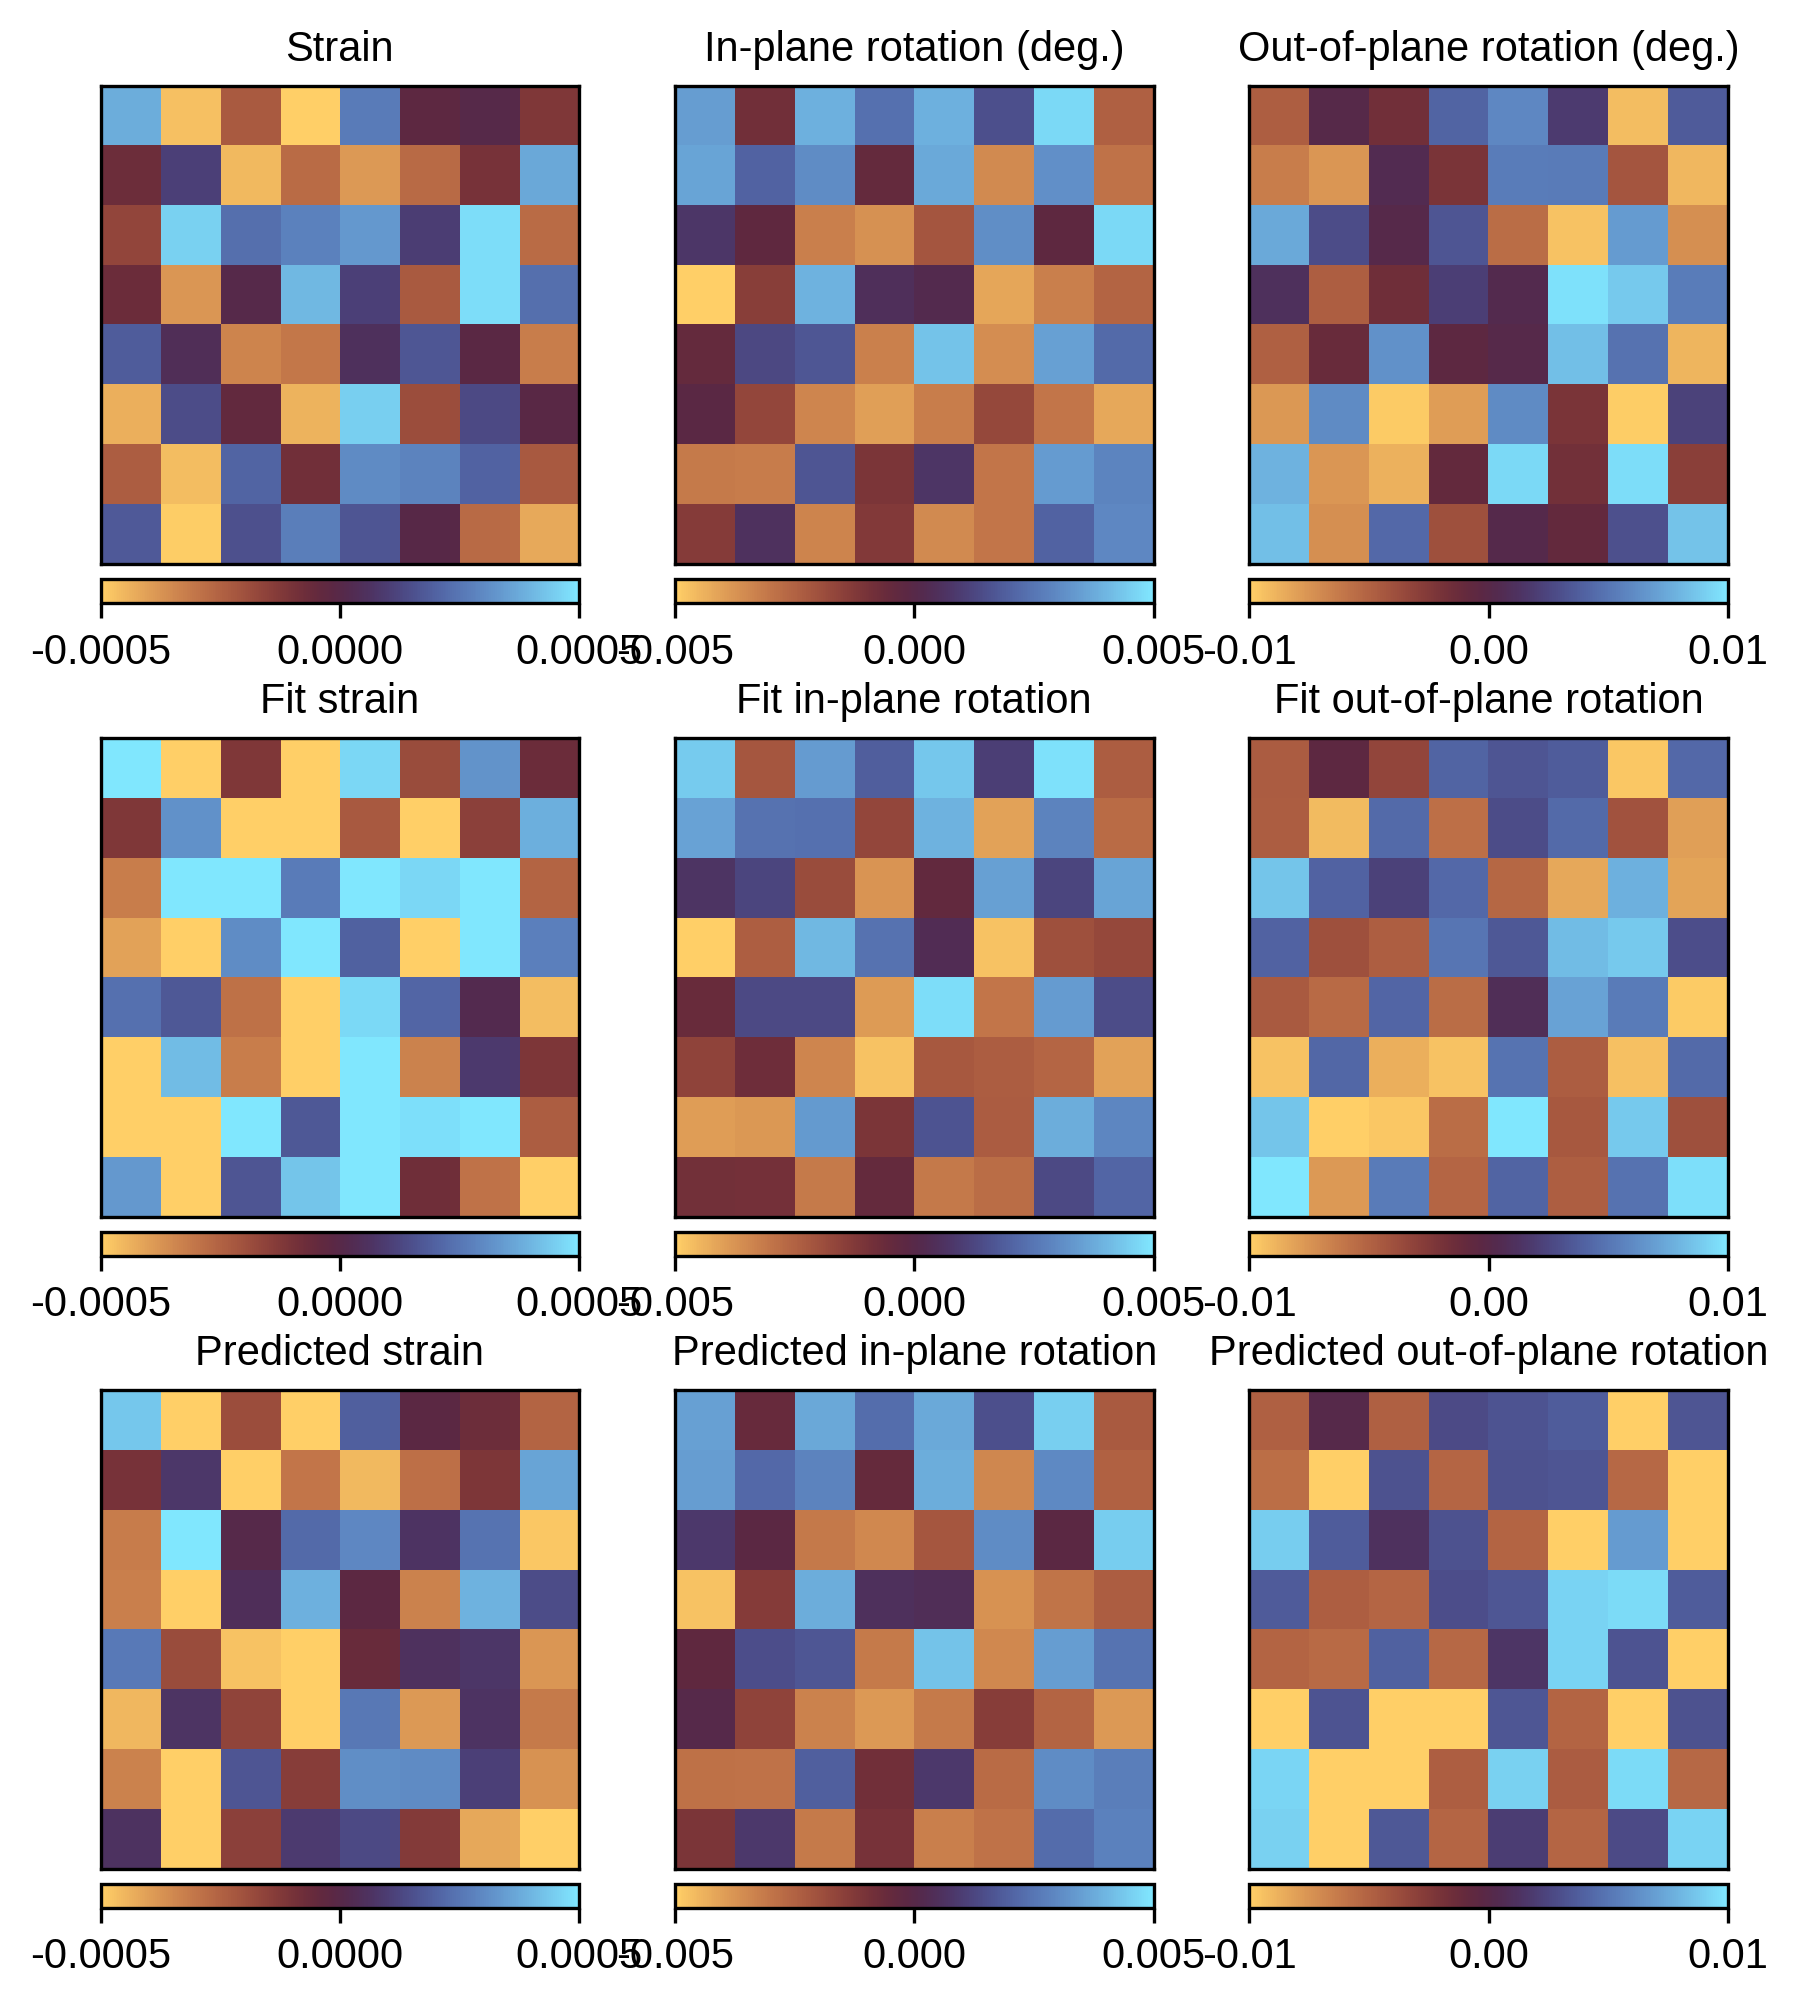

In [13]:
# Refer to Figure S11 of the Supplementary Information

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(7, 8), nrows=3, ncols=3)

vmin0 = -0.0005
vmax0 = 0.0005
vmin1 = -0.005
vmax1 = 0.005
vmin2 = -0.01
vmax2 = 0.01

im0 = ax[0, 0].imshow(gt_strain, interpolation='none', vmin=vmin0, vmax=vmax0, cmap=cmc.managua)
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im0, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 0].set_title('Strain')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

im1 = ax[0, 1].imshow(gt_tilt_lr, interpolation='none', vmin=vmin1, vmax=vmax1, cmap=cmc.managua)
divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='horizontal', format='%.3f')
ax[0, 1].set_title('In-plane rotation (deg.)')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

im2 = ax[0, 2].imshow(gt_tilt_ud, interpolation='none', vmin=vmin2, vmax=vmax2, cmap=cmc.managua)
divider = make_axes_locatable(ax[0, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im2, cax=cax, orientation='horizontal', format='%.2f')
ax[0, 2].set_title('Out-of-plane rotation (deg.)')
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

fit_im0 = ax[1, 0].imshow(sim_strain_fit, interpolation='none', vmin=vmin0, 
                          vmax=vmax0, cmap=cmc.managua)
divider = make_axes_locatable(ax[1, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(fit_im0, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 0].set_title('Fit strain')
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

fit_im1 = ax[1, 1].imshow(sim_tilt_lr_fit, interpolation='none', vmin=vmin1, vmax=vmax1, 
                          cmap=cmc.managua)
divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(fit_im1, cax=cax, orientation='horizontal', format='%.3f')
ax[1, 1].set_title('Fit in-plane rotation')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

fit_im2 = ax[1, 2].imshow(sim_tilt_ud_fit, interpolation='none', vmin=vmin2, vmax=vmax2, 
                          cmap=cmc.managua)
divider = make_axes_locatable(ax[1, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(fit_im2, cax=cax, orientation='horizontal', format='%.2f')
ax[1, 2].set_title('Fit out-of-plane rotation')
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

pred_im0 = ax[2, 0].imshow(pred_sim_strain, interpolation='none', vmin=vmin0, vmax=vmax0, cmap=cmc.managua)
divider = make_axes_locatable(ax[2, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred_im0, cax=cax, orientation='horizontal', format='%.4f')
ax[2, 0].set_title('Predicted strain')
ax[2, 0].set_xticks([])
ax[2, 0].set_yticks([])

pred_im1 = ax[2, 1].imshow(pred_sim_tilt_lr, interpolation='none', vmin=vmin1, vmax=vmax1, cmap=cmc.managua)
divider = make_axes_locatable(ax[2, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred_im1, cax=cax, orientation='horizontal', format='%.3f')
ax[2, 1].set_title('Predicted in-plane rotation')
ax[2, 1].set_xticks([])
ax[2, 1].set_yticks([])

pred_im2 = ax[2, 2].imshow(pred_sim_tilt_ud, interpolation='none', vmin=vmin2, vmax=vmax2, cmap=cmc.managua)
divider = make_axes_locatable(ax[2, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred_im2, cax=cax, orientation='horizontal', format='%.2f')
ax[2, 2].set_title('Predicted out-of-plane rotation')
ax[2, 2].set_xticks([])
ax[2, 2].set_yticks([])

#f.savefig('figs11.svg', dpi=300, bbox_inches='tight', transparent=True)

In [14]:
# Stats
fit_error_strain = sim_strain_fit - gt_strain
print('Avg. strain fit error: ', np.mean(fit_error_strain), '| Std. dev.: ', np.std(fit_error_strain))
fit_error_tilt_lr = sim_tilt_lr_fit - gt_tilt_lr
print('Avg. tilt_lr fit error: ', np.mean(fit_error_tilt_lr), '| Std. dev.: ', np.std(fit_error_tilt_lr))
fit_error_tilt_ud = sim_tilt_ud_fit - gt_tilt_ud
print('Avg. tilt_ud fit error: ', np.mean(fit_error_tilt_ud), '| Std. dev.: ', np.std(fit_error_tilt_ud))

pred_error_strain = pred_sim_strain - gt_strain
print('Avg. strain prediction error: ', np.mean(pred_error_strain), '| Std. dev.: ', np.std(pred_error_strain))
pred_error_tilt_lr = pred_sim_tilt_lr - gt_tilt_lr
print('Avg. tilt_lr prediction error: ', np.mean(pred_error_tilt_lr), '| Std. dev.: ', np.std(pred_error_tilt_lr))
pred_error_tilt_ud = pred_sim_tilt_ud - gt_tilt_ud
print('Avg. tilt_ud prediction error: ', np.mean(pred_error_tilt_ud), '| Std. dev.: ', np.std(pred_error_tilt_ud))

Avg. strain fit error:  4.363440310294464e-05 | Std. dev.:  0.00022569721222867375
Avg. tilt_lr fit error:  8.194246020905969e-05 | Std. dev.:  0.0008025612090427876
Avg. tilt_ud fit error:  -0.0002856692755959004 | Std. dev.:  0.002013053012251861
Avg. strain prediction error:  -9.86189877469289e-05 | Std. dev.:  9.790230921412909e-05
Avg. tilt_lr prediction error:  0.0001047593793450081 | Std. dev.:  0.00018265556987588703
Avg. tilt_ud prediction error:  -0.0010856777956323995 | Std. dev.:  0.0019445061552181813


## Correlation fitting process demonstration

In [15]:
sim_mat = np.load(os.path.join(data_folder, 'sim_data.npy')).astype('float32')

sim_mat[np.isnan(sim_mat)] = 0
sim_mat /= sim_mat.sum(axis=(3, 4), keepdims=True)

In [16]:
# Index 43 of simulated scan, refer to Fig. S11
dd_sum = (sim_sample[43:44, np.newaxis, np.newaxis, np.newaxis]*sim_mat).sum(axis=(4, 5))

dd_sum_s = dd_sum.sum(axis=(2, 3))
dd_sum_s -= np.min(dd_sum_s, axis=1, keepdims=True)

dd_sum_lr = dd_sum.sum(axis=(1, 3))
dd_sum_lr -= np.min(dd_sum_lr, axis=1, keepdims=True)

dd_sum_ud = dd_sum.sum(axis=(1, 2))
dd_sum_ud -= np.min(dd_sum_ud, axis=1, keepdims=True)

i_s = (dd_sum_s*np.arange(41, dtype=np.float32)).sum(axis=(1))/dd_sum_s.sum(axis=(1))
s = (i_s-20)*0.00025

i_lr = (dd_sum_lr*np.arange(41, dtype=np.float32)).sum(axis=(1))/dd_sum_lr.sum(axis=(1))
lr = (i_lr-20)*0.0025

i_ud = (dd_sum_ud*np.arange(41, dtype=np.float32)).sum(axis=(1))/dd_sum_ud.sum(axis=(1))
ud = (i_ud-20)*0.005

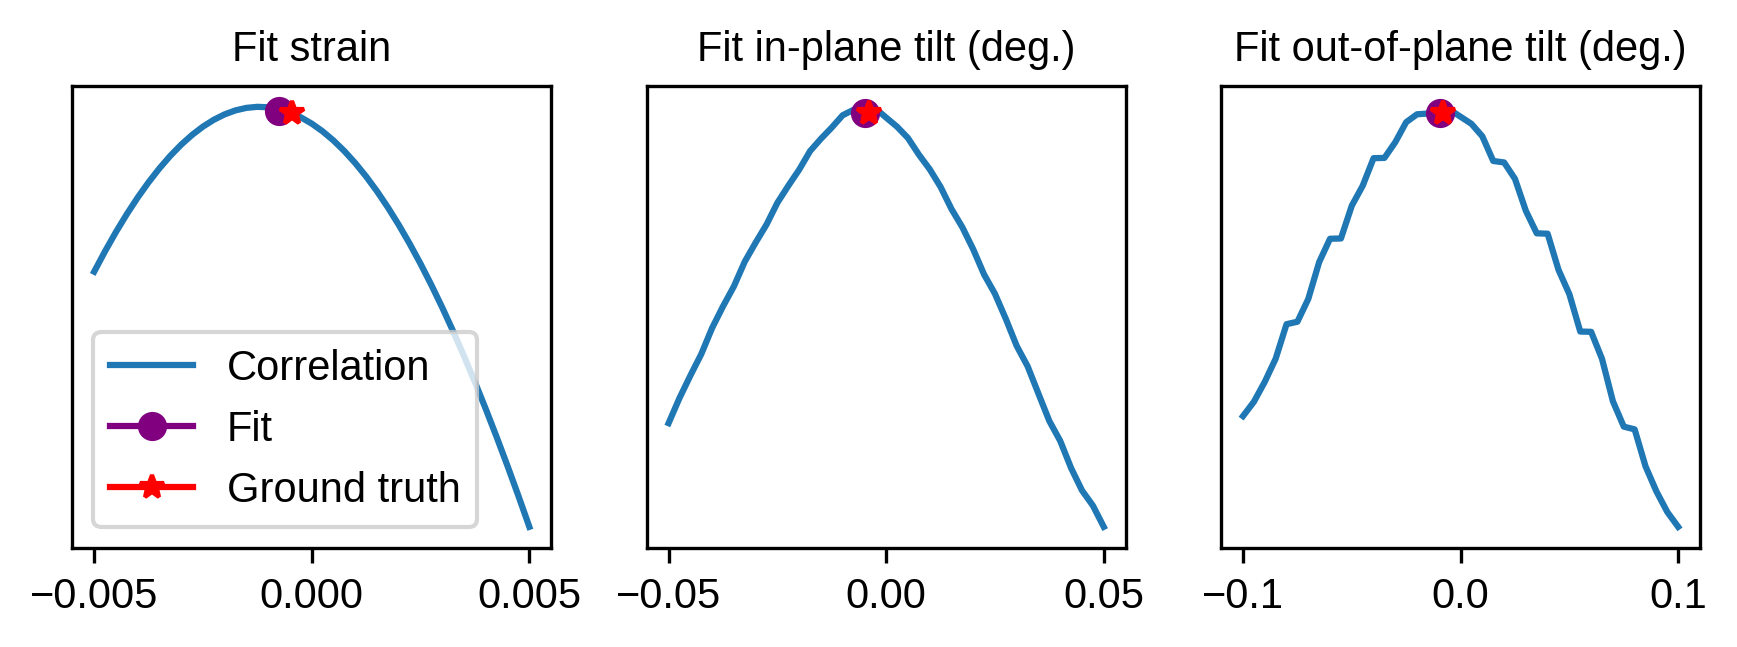

In [22]:
matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(7, 2), ncols=3)
ax[0].plot(np.linspace(-0.005, 0.005, 41), dd_sum_s[0], label='Correlation')
ax[0].plot(s, 510, marker='o', color='purple', label='Fit')
ax[0].plot(gt_strain[5, 3], 508, marker='*', color='red', label='Ground truth')
ax[0].legend()
ax[0].set_title('Fit strain')
ax[0].set_yticks([])

ax[1].plot(np.linspace(-0.05, 0.05, 41), dd_sum_lr[0])
ax[1].plot(lr, 2520, marker='o', color='purple')
ax[1].plot(gt_tilt_lr[5, 3], 2520, marker='*', color='red')
ax[1].set_title('Fit in-plane tilt (deg.)')
ax[1].set_yticks([])

ax[2].plot(np.linspace(-0.1, 0.1, 41), dd_sum_ud[0])
ax[2].plot(ud, 2470, marker='o', color='purple')
ax[2].plot(gt_tilt_ud[5, 3], 2470, marker='*', color='red')
ax[2].set_title('Fit out-of-plane tilt (deg.)')
ax[2].set_yticks([])

f.savefig('figs11b.svg', dpi=300, bbox_inches='tight', transparent=True)

In [21]:
gt_strain[5, 3], gt_tilt_lr[5, 3], gt_tilt_ud[5, 3]

(-0.0004429841486440971, -0.00401309186061905, -0.007918076193650425)